# Google's QuickDraw: Image Classification


#### Numpy bitmaps (`.npy`)
All the simplified drawings have been rendered into a 28x28 grayscale bitmap in numpy `.npy` format. The files can be loaded with [`np.load()`](https://docs.scipy.org/doc/numpy-1.12.0/reference/generated/numpy.load.html). These images were generated from the simplified data, but are aligned to the center of the drawing's bounding box rather than the top-left corner.

In [1]:
import skimage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import itertools
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV

<center><h1> Data Wrangling </h1></center>



In [2]:
files = glob("data/numpy_bitmap/*.npy")
files

['data/numpy_bitmap\\ambulance.npy',
 'data/numpy_bitmap\\baseball.npy',
 'data/numpy_bitmap\\beard.npy',
 'data/numpy_bitmap\\bridge.npy',
 'data/numpy_bitmap\\calculator.npy',
 'data/numpy_bitmap\\cat.npy',
 'data/numpy_bitmap\\lightbulb.npy',
 'data/numpy_bitmap\\octopus.npy',
 'data/numpy_bitmap\\smileyface.npy',
 'data/numpy_bitmap\\wristwatch.npy']

In [3]:
# load each class separately
ambulance = np.load('data/numpy_bitmap/ambulance.npy')
baseball = np.load('data/numpy_bitmap/baseball.npy')
beard = np.load('data/numpy_bitmap/beard.npy')
bridge = np.load('data/numpy_bitmap/bridge.npy')
calculator = np.load('data/numpy_bitmap/calculator.npy')
cat = np.load('data/numpy_bitmap/cat.npy')
lightbulb = np.load('data/numpy_bitmap/lightbulb.npy')
octopus = np.load('data/numpy_bitmap/octopus.npy')
smileyface = np.load('data/numpy_bitmap/smileyface.npy')
wristwatch = np.load('data/numpy_bitmap/wristwatch.npy')

In [42]:
type(wristwatch[0])

numpy.ndarray

In [4]:
# Add class label to each array
ambulance = np.c_[ambulance, np.zeros(len(ambulance))]
baseball = np.c_[baseball, np.ones(len(baseball))]
beard = np.c_[beard, 2*np.ones(len(beard))]
bridge = np.c_[bridge, 3*np.ones(len(bridge))]
calculator = np.c_[calculator, 4*np.ones(len(calculator))]
cat = np.c_[cat, 5*np.ones(len(cat))]
lightbulb = np.c_[lightbulb, 6*np.ones(len(lightbulb))]
octopus = np.c_[octopus, 7*np.ones(len(octopus))]
smileyface = np.c_[smileyface, 8*np.ones(len(smileyface))]
wristwatch = np.c_[wristwatch, 9*np.ones(len(wristwatch))]

In [5]:
# store the label codes in a dictionary
label_dict = {0:'ambulance', 1:'baseball', 2:'beard', 3:'bridge', 4:'calculator',
              5:'cat', 6:'lightbulb', 7:'octopus', 8:'smileyface', 9:'wristwatch'
              }
# store the arrays in a list
arrays = [ambulance,baseball,beard,bridge,calculator,cat,lightbulb,octopus,smileyface,wristwatch]

In [6]:
# Examine shape of each category
for k, item in enumerate(arrays):
    print(label_dict[k],'shape: ',item.shape)

ambulance shape:  (148004, 785)
baseball shape:  (135375, 785)
beard shape:  (165202, 785)
bridge shape:  (133010, 785)
calculator shape:  (128375, 785)
cat shape:  (123202, 785)
lightbulb shape:  (120879, 785)
octopus shape:  (150152, 785)
smileyface shape:  (124386, 785)
wristwatch shape:  (162645, 785)


In [7]:
# List of 1000 drawings for each category without label
short_arrays_X = []
# List of 1000 drawings' label for each cateogry
short_arrays_Y = []

for item in arrays:
    short_arrays_X.append(item[:2000,:784])
    short_arrays_Y.append(item[:2000,-1])
# Create our traing/test split data and normalize the features between 0 and 1   
X = np.concatenate(short_arrays_X, axis=0).astype('float32')/255.
y = np.concatenate(short_arrays_Y, axis=0).astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

In [8]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0.0: 615,
 1.0: 613,
 2.0: 624,
 3.0: 570,
 4.0: 628,
 5.0: 604,
 6.0: 595,
 7.0: 583,
 8.0: 566,
 9.0: 602}

<center><h1> Image Preprocessing / Exploratory Analysis </h1></center>

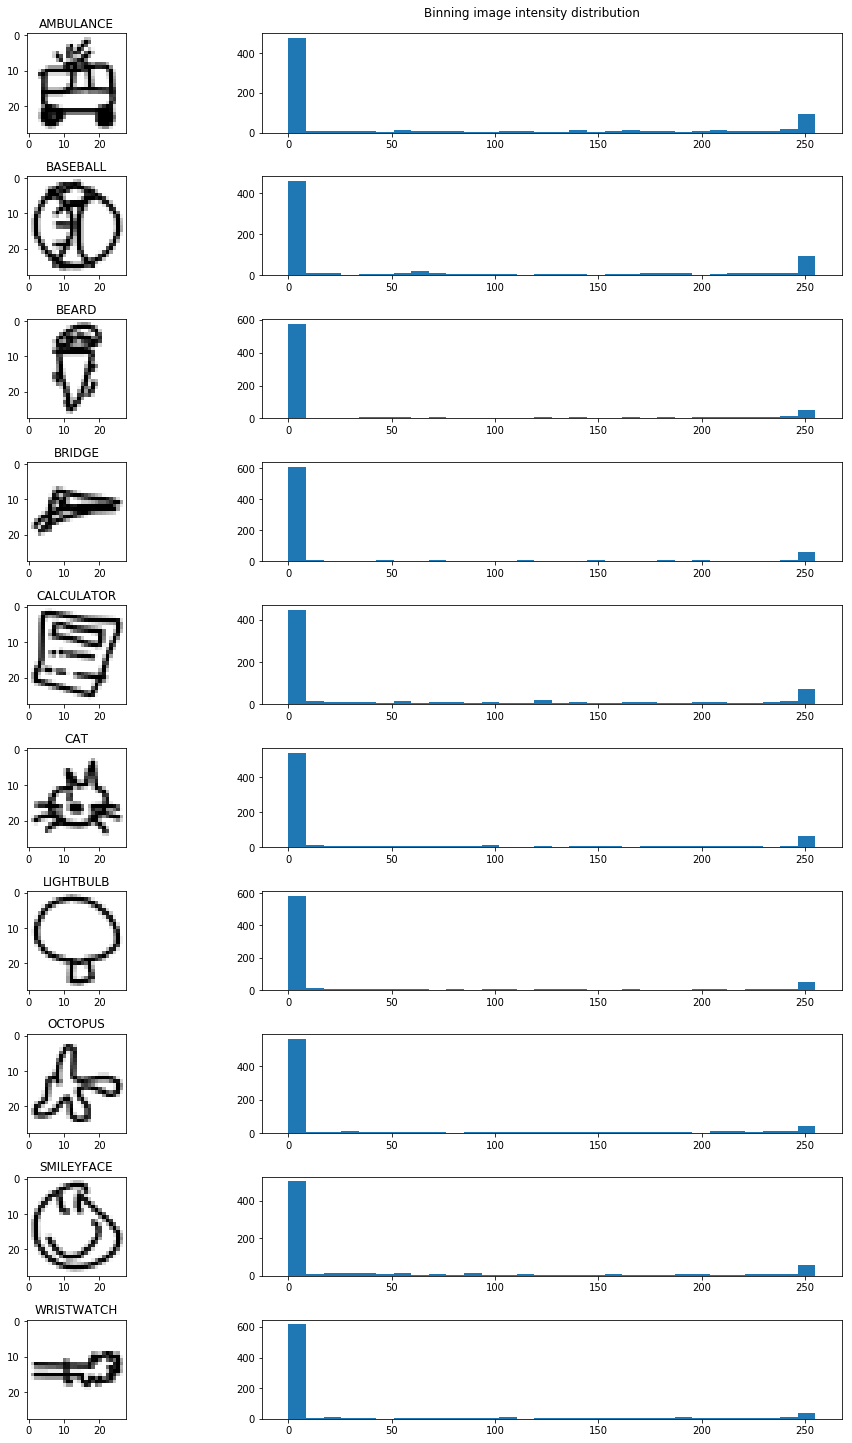

In [9]:
# Create Image Intensity Histrogram for each class
freq = []
bins = []
patches = []

fig, axs = plt.subplots(10, 2, figsize=(15,20))
plt.suptitle('Binning image intensity distribution', x=.7,y=1)
for i, array in enumerate(arrays):
    axs[i,0].set_title(label_dict[i].upper())
    axs[i,0].imshow(array[0,:784].reshape((28,28)), cmap="gray_r")
    a_freq, a_bins, a_patches = axs[i,1].hist(array[0,:784].reshape((28,28)).flatten(), bins=30,)
    freq.append(a_freq)
    bins.append(a_bins)
    patches.append(a_patches)
plt.tight_layout()

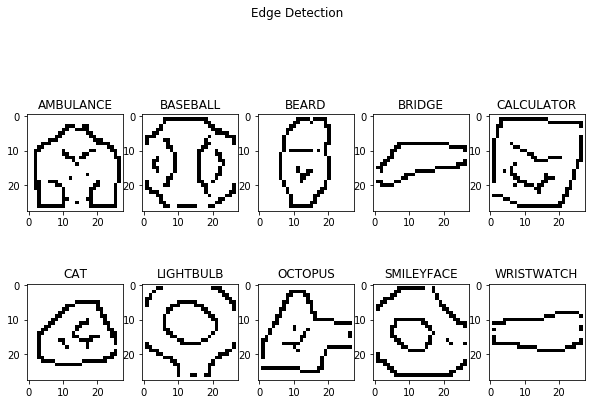

In [10]:
from skimage.feature import canny
fig = plt.figure(figsize=(10,7))
edges = []
plt.suptitle('Edge Detection')
plt.subplots_adjust(hspace=-.2)
for i, array in enumerate(arrays):
    ax = fig.add_subplot(2,5,i+1)
    edge = canny(array[0,:784].reshape((28,28)), sigma=3)
    plt.imshow(edge, cmap='binary')
    edges.append(edge)
    plt.title(label_dict[i].upper())
    

<center><h1>Modeling</h1></center>

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

## K-Nearest Neighbor

In [12]:
knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(X_train, y_train)
print(knn)
y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
print ('KNN accuracy: ',acc_knn)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')
KNN accuracy:  0.768166666667


In [13]:
parameters = {'n_neighbors': np.arange(2,6,1)}

knn = KNeighborsClassifier(n_jobs=-1)
knn = GridSearchCV(knn, parameters, n_jobs=-1)
knn.fit(X_train, y_train)

results_knn = pd.DataFrame(knn.cv_results_)
results_knn.sort_values('mean_test_score', ascending = False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_neighbors,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
3,8.650211,160.607327,0.755286,0.840571,4,{'n_neighbors': 4},1,0.756155,0.841355,0.758465,0.838976,0.751233,0.841384,1.954845,0.978023,0.003015,0.001128
5,8.734906,129.387831,0.751929,0.813178,6,{'n_neighbors': 6},2,0.752516,0.811019,0.755679,0.814442,0.747587,0.814073,1.260780,29.046055,0.003329,0.001534
4,7.255375,168.255438,0.747714,0.818714,5,{'n_neighbors': 5},3,0.751231,0.818630,0.747750,0.818620,0.744156,0.818893,0.786994,1.320918,0.002889,0.000126
2,7.534857,168.006265,0.746000,0.855072,3,{'n_neighbors': 3},4,0.745451,0.856791,0.746464,0.856546,0.746086,0.851880,1.877536,6.694877,0.000418,0.002260
6,6.691157,106.208383,0.743786,0.797357,7,{'n_neighbors': 7},5,0.742882,0.796548,0.747535,0.796979,0.740939,0.798543,0.949251,2.336624,0.002767,0.000857
0,1.912380,162.134569,0.738857,1.000000,1,{'n_neighbors': 1},6,0.734532,1.000000,0.738963,1.000000,0.743084,1.000000,0.361358,5.046647,0.003492,0.000000
1,4.136730,170.863649,0.737071,0.891214,2,{'n_neighbors': 2},7,0.737529,0.891735,0.740249,0.890722,0.733433,0.891186,0.581439,0.724683,0.002800,0.000414


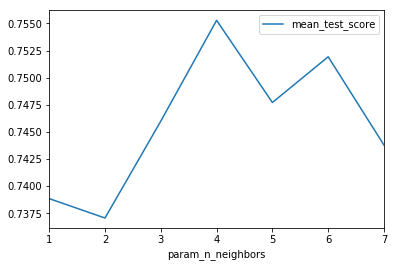

In [14]:
results_knn.plot('param_n_neighbors','mean_test_score')

## Random Forest 

In [15]:
rfc = RandomForestClassifier(random_state=1)
rfc.fit(X_train, y_train)
print(rfc)
y_pred_rfc = rfc.predict(X_test)
acc_rfc = accuracy_score(y_test, y_pred_rfc)
print ('Random forest accuracy: ',acc_rfc)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)
Random forest accuracy:  0.685666666667


In [16]:
parameters = {'n_estimators': np.arange(10,150,10)}
rfc = RandomForestClassifier(random_state=1, n_jobs=-1)
rfc_gs = GridSearchCV(rfc, parameters)
rfc_gs.fit(X_train, y_train)

results_rfc_gs = pd.DataFrame(rfc_gs.cv_results_)

In [17]:
results_rfc_gs.sort_values('mean_test_score', ascending = False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
13,2.648423,0.209853,0.767357,1.000000,140,{'n_estimators': 140},1,0.771997,1.000000,0.763395,1.000000,0.766674,1.000000,0.083711,0.000721,0.003546,0.000000
12,2.458763,0.142227,0.766071,1.000000,130,{'n_estimators': 130},2,0.770071,1.000000,0.762109,1.000000,0.766030,1.000000,0.111131,0.049706,0.003251,0.000000
11,2.219804,0.176938,0.765714,1.000000,120,{'n_estimators': 120},3,0.769857,1.000000,0.762323,1.000000,0.764958,1.000000,0.005774,0.049425,0.003122,0.000000
10,2.157736,0.109521,0.762857,1.000000,110,{'n_estimators': 110},4,0.766645,1.000000,0.758251,1.000000,0.763671,1.000000,0.085229,0.003542,0.003476,0.000000
9,1.875051,0.106906,0.762357,1.000000,100,{'n_estimators': 100},5,0.763862,1.000000,0.761037,1.000000,0.762170,1.000000,0.023721,0.001026,0.001161,0.000000
7,1.594735,0.110263,0.762000,1.000000,80,{'n_estimators': 80},6,0.763648,1.000000,0.757823,1.000000,0.764529,1.000000,0.036763,0.003389,0.002975,0.000000
8,1.736514,0.106757,0.761929,1.000000,90,{'n_estimators': 90},7,0.764504,1.000000,0.759323,1.000000,0.761956,1.000000,0.036070,0.000417,0.002116,0.000000
6,1.332257,0.107890,0.757714,1.000000,70,{'n_estimators': 70},8,0.761079,1.000000,0.755465,1.000000,0.756594,1.000000,0.007120,0.000701,0.002425,0.000000
5,1.168019,0.109067,0.754786,0.999964,60,{'n_estimators': 60},9,0.759580,0.999893,0.751822,1.000000,0.752949,1.000000,0.047879,0.002861,0.003424,0.000051
4,1.021062,0.109251,0.751500,0.999964,50,{'n_estimators': 50},10,0.757654,0.999893,0.747321,1.000000,0.749517,1.000000,0.037588,0.002590,0.004446,0.000051


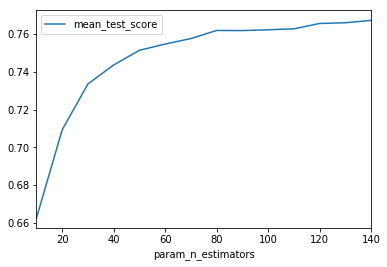

In [18]:
results_rfc_gs.plot('param_n_estimators','mean_test_score')

In [41]:
parameters = {'max_features':['sqrt',.1,.3,.5,.7,.99]}

rfc = RandomForestClassifier(n_estimators= 80, random_state=1, n_jobs=-1)
rfc_gs = GridSearchCV(rfc, parameters, n_jobs=-1)
rfc_gs.fit(X_train, y_train)

results_rfc_gs = pd.DataFrame(rfc_gs.cv_results_)
results_rfc_gs.sort_values('mean_test_score', ascending = False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_features,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,5.120579,4.041717,0.761929,1.0,sqrt,{'max_features': 'sqrt'},1,0.763648,1.0,0.757823,1.0,0.764315,1.0,1.540226,1.076913,0.002916,0.0
1,21.396071,4.868914,0.760286,1.0,0.1,{'max_features': 0.1},2,0.763648,1.0,0.755251,1.0,0.761956,1.0,0.761026,0.220410,0.003626,0.0
2,71.535193,6.152427,0.759786,1.0,0.3,{'max_features': 0.3},3,0.762149,1.0,0.754608,1.0,0.762599,1.0,1.685276,0.510325,0.003666,0.0
3,123.848430,6.160301,0.758429,1.0,0.5,{'max_features': 0.5},4,0.766003,1.0,0.751393,1.0,0.757881,1.0,0.959323,0.197468,0.005978,0.0
4,157.419768,3.525996,0.752143,1.0,0.7,{'max_features': 0.7},5,0.757654,1.0,0.747535,1.0,0.751233,1.0,10.823597,0.522408,0.004181,0.0
5,150.765659,0.468227,0.744857,1.0,0.99,{'max_features': 0.99},6,0.752944,1.0,0.737034,1.0,0.744585,1.0,25.775075,0.265694,0.006499,0.0


In [20]:
rfc = RandomForestClassifier(n_estimators=60, max_features=.3, random_state=1)
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)
acc_rfc = accuracy_score(y_test, y_pred_rfc)
print ('Random forest accuracy: ',acc_rfc)

Random forest accuracy:  0.772666666667


Text(0.5,1.05,'Pixel importances\n')

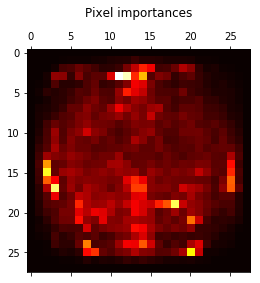

In [21]:
importances = rfc.feature_importances_
importances = importances.reshape((28,28))
fig = plt.matshow(importances, cmap=plt.cm.hot)
plt.title('Pixel importances\n')

# Support Vector Machine 
We can compared a linear support-vector model and a non-linear support-vector model
#### LinearSVC

In [22]:
lsvc = LinearSVC(random_state=1)
lsvc.fit(X_train, y_train)
print(lsvc)
y_pred_lsvc = lsvc.predict(X_test)
acc_lsvc = accuracy_score(y_test, y_pred_lsvc)
print('Linear SVC accuracy: ',acc_lsvc)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
     verbose=0)
Linear SVC accuracy:  0.662333333333


#### SGDClassifier

In [23]:
svc = SVC(kernel='rbf', random_state=1) 
svc.fit(X_train, y_train)
print(svc)
y_pred_svc = svc.predict(X_test)
acc_svc = accuracy_score(y_test, y_pred_svc)
print ('Gaussian Radial Basis Function SVC Accuracy: ',acc_svc)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False)
Gaussian Radial Basis Function SVC Accuracy:  0.75


# Multi-Layer Perceptron

In [24]:
mlp = MLPClassifier(random_state=1)
mlp.fit(X_train, y_train)
print(mlp)
y_pred_mlp = mlp.predict(X_test)
acc_mlp = accuracy_score(y_test, y_pred_mlp)
print ('mlp accuracy: ',acc_mlp)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
mlp accuracy:  0.780333333333


For tuning the hyper-parameters for a Multi-Layer Perceptron, we can try different number of layers. The default activiation function (ReLu) is the most effective choice from sklearn and the the defualt optimization algorithm (adam) is the best choice due to the size of our dataset. 

In [25]:
parameters = {'hidden_layer_sizes' : [(784,), (784,784),(784,784,784)] }

mlp = MLPClassifier(random_state=1)
mlp = GridSearchCV(mlp, parameters, n_jobs=-1)
mlp.fit(X_train, y_train)

results=pd.DataFrame(mlp.cv_results_)
results.sort_values('mean_test_score', ascending = False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_hidden_layer_sizes,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
1,571.174946,0.518413,0.801143,1.000000,"(784, 784)","{'hidden_layer_sizes': (784, 784)}",1,0.805609,1.00000,0.794042,1.000000,0.803774,1.000000,16.364282,0.038592,0.005076,0.000000
0,660.484900,0.204058,0.797714,1.000000,"(784,)","{'hidden_layer_sizes': (784,)}",2,0.803254,1.00000,0.791899,1.000000,0.797984,1.000000,3.740682,0.023213,0.004641,0.000000
2,419.653466,0.720471,0.783571,0.993786,"(784, 784, 784)","{'hidden_layer_sizes': (784, 784, 784)}",3,0.787626,0.99657,0.775825,0.991751,0.787261,0.993038,116.113026,0.254860,0.005479,0.002037


## Convolution Neural Network

In [26]:
import keras
from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [27]:
# one hot encode outputs
y_train_cnn = np_utils.to_categorical(y_train)
y_test_cnn = np_utils.to_categorical(y_test)
num_classes = y_test_cnn.shape[1]

# reshape to be [samples][width][height][pixels] 
X_train_cnn = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test_cnn = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

In [28]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu',input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

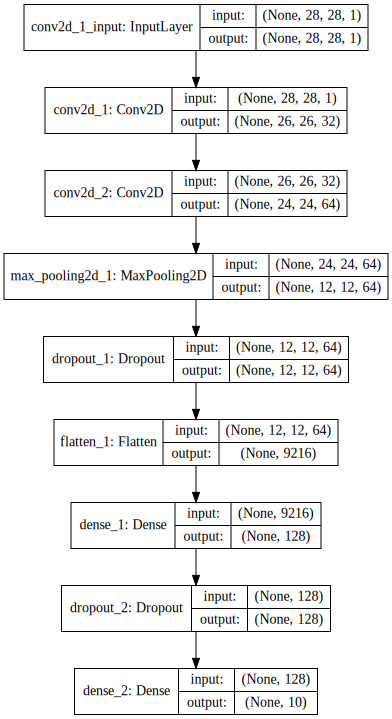

In [29]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, 
                 show_layer_names=True, rankdir='TB').create(prog='dot', format='svg'))

In [30]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [31]:
cnn_model = model.fit(X_train_cnn, y_train_cnn,
          batch_size=64,
          epochs=10,
          validation_data=(X_test_cnn, y_test_cnn))

Train on 14000 samples, validate on 6000 samples
Epoch 1/10
14000/14000 [==============================] - 34s 2ms/step - loss: 0.9917 - acc: 0.6841 - val_loss: 0.5411 - val_acc: 0.8402
Epoch 2/10
14000/14000 [==============================] - 35s 2ms/step - loss: 0.5859 - acc: 0.8214 - val_loss: 0.4338 - val_acc: 0.8665
Epoch 3/10
14000/14000 [==============================] - 34s 2ms/step - loss: 0.4870 - acc: 0.8537 - val_loss: 0.3992 - val_acc: 0.8757
Epoch 4/10
14000/14000 [==============================] - 33s 2ms/step - loss: 0.4145 - acc: 0.8746 - val_loss: 0.3787 - val_acc: 0.8875
Epoch 5/10
14000/14000 [==============================] - 33s 2ms/step - loss: 0.3688 - acc: 0.8836 - val_loss: 0.3728 - val_acc: 0.8887
Epoch 6/10
14000/14000 [==============================] - 34s 2ms/step - loss: 0.3158 - acc: 0.9003 - val_loss: 0.3635 - val_acc: 0.8938
Epoch 7/10
14000/14000 [==============================] - 35s 2ms/step - loss: 0.2717 - acc: 0.9121 - val_loss: 0.3714 - val_acc:

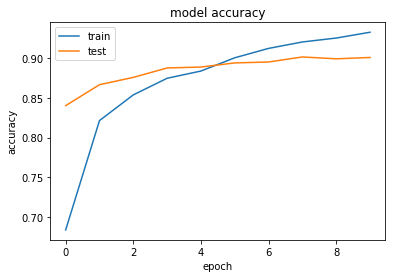

In [32]:
plt.plot(cnn_model.history['acc'])
plt.plot(cnn_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
score = model.evaluate(X_test_cnn, y_test_cnn, verbose=1)

6000/6000 [==============================] - 4s 656us/step


In [34]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.365115616779
Test accuracy: 0.900666666667


In [35]:
test_image =np.expand_dims(X_test_cnn[0], axis=3)
test_image = test_image.reshape(1,28, 28,1)

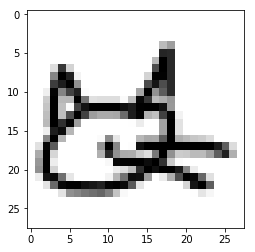

In [36]:
plt.imshow(X_test_cnn[0][:,:,0], cmap=plt.get_cmap('binary'))

In [37]:
y_test_cnn[0]

array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.])

In [38]:
model.predict_classes(test_image,batch_size=1)

array([5], dtype=int64)

In [39]:
y_pred_cnn = model.predict_classes(X_test_cnn, verbose=0)

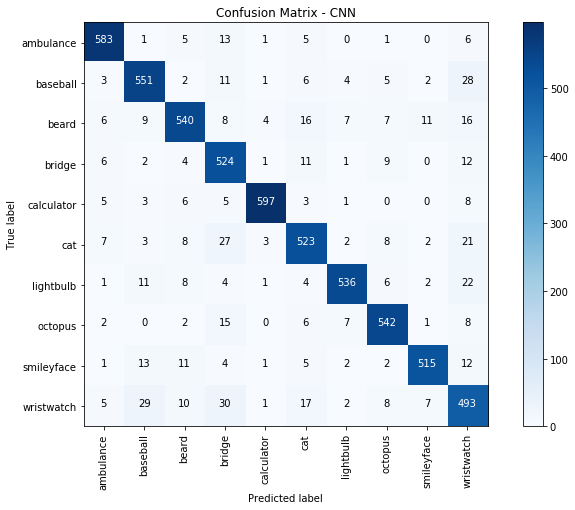

In [40]:
# Compute confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_cnn)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(10,7))
fig = plt.imshow(cf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
_ =plt.title('Confusion Matrix - CNN')
_ = plt.colorbar()
_ = tick_marks = np.arange(len(label_dict))
_ = plt.xticks(tick_marks, label_dict.values(), rotation=90)
_ = plt.yticks(tick_marks, label_dict.values())
_ = plt.tight_layout()
_ = plt.ylabel('True label')
_ = plt.xlabel('Predicted label')
thresh = cf_matrix.max() / 2.
for i, j in itertools.product(range(cf_matrix.shape[0]), range(cf_matrix.shape[1])):
    plt.text(j, i, cf_matrix[i, j], horizontalalignment="center",
                color="white" if cf_matrix[i, j] > thresh else "black")